In [36]:
!nvidia-smi

Sun Oct 12 08:50:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             35W /   70W |     158MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import time

In [38]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

data = fetch_openml(name="boston", version=1, as_frame=True)
df = data.frame

x = df.drop("MEDV", axis=1).values
y = df["MEDV"].values.reshape(-1,1)

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42)


scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)


x_train_tensor = torch.FloatTensor(x_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
x_val_tensor = torch.FloatTensor(x_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)
x_test_tensor = torch.FloatTensor(x_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using: cuda


In [39]:
print(data.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [40]:
class LinearRegression(nn.Module):
  def __init__(self, input_dim):
    super(LinearRegression, self).__init__()
    self.linear = nn.Linear(input_dim, 1)

  def forward(self, x):
    return self.linear(x)


model = LinearRegression(input_dim=x_train.shape[1]).to(device)
print(model)



LinearRegression(
  (linear): Linear(in_features=13, out_features=1, bias=True)
)


In [41]:
def train_model(model, train_loader, val_loader, epochs=1000, lr=0.01, patience=10):
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)


  train_losses, val_losses = [], []
  train_r2, val_r2 = [], []
  best_val_loss = float('inf')
  epchs_no_improve = 0

  start_time = time.time()
  for epoch in range(epochs):
    model.train()
    train_loss = 0
    y_train_pred = []
    y_train_true = []
    for inputs, targets in train_loader:
      optimizer.zero_grad()
      outputs  = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      y_train_pred.extend(outputs.cpu().detach().numpy())
      y_train_true.extend(targets.cpu().detach().numpy())
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r2_score(y_train_true, y_train_pred))

    model.eval()
    val_loss = 0
    y_val_pred = []
    y_val_true = []
    with torch.no_grad():
      for inputs, targets in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss += loss.item()
        y_val_pred.extend(outputs.cpu().detach().numpy())
        y_val_true.extend(targets.cpu().detach().numpy())
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r2_score(y_val_true, y_val_pred))

    scheduler.step(val_loss)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      epochs_no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')
    else:
      epochs_no_improve += 1
      if epochs_no_improve >= patience:
        print(f"Early Stopping at epoch: {epoch}")
        break


    if (epoch + 1) % 100 ==0:
      print(f"Epoch {epoch+1}/{epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train R2 Score{train_r2[-1]:.4f}, Val R2 Score: {val_r2[-1]:.4f}")


  model.load_state_dict(torch.load('best_model.pth'))

  end_time = time.time()
  total_time = end_time - start_time

  return train_losses, val_losses, train_r2, val_r2, total_time


train_losses, val_losses, train_r2, val_r2, total_time = train_model(model, train_loader, val_loader, epochs=1000, lr=0.01, patience=10)
print(f"Training time: {total_time:.2f} seconds")

Epoch 100/99, Train Loss: 214.3962, Val Loss: 204.0526, Train R2 Score-1.3990, Val R2 Score: -1.7500
Epoch 200/199, Train Loss: 71.2840, Val Loss: 65.7067, Train R2 Score0.2021, Val R2 Score: 0.0714
Epoch 300/299, Train Loss: 29.4602, Val Loss: 24.2779, Train R2 Score0.6836, Val R2 Score: 0.6215
Epoch 400/399, Train Loss: 24.1618, Val Loss: 18.1556, Train R2 Score0.7553, Val R2 Score: 0.7101
Early Stopping at epoch: 409
Training time: 7.54 seconds


In [42]:
def evaluate_model(model, test_loader):
  model.eval()
  criterion = nn.MSELoss()
  test_loss = 0
  y_test_pred = []
  y_test_true = []
  with torch.no_grad():
    for inputs, targets in test_loader:
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss += loss.item()
      y_test_pred.extend(outputs.cpu().detach().numpy())
      y_test_true.extend(targets.cpu().detach().numpy())
  test_loss /= len(test_loader)
  test_r2 = r2_score(y_test_true, y_test_pred)
  print(f"Test Loss (MSE): {test_loss:.4f}")
  print(f"Test R2 Score: {test_r2:.4f}")

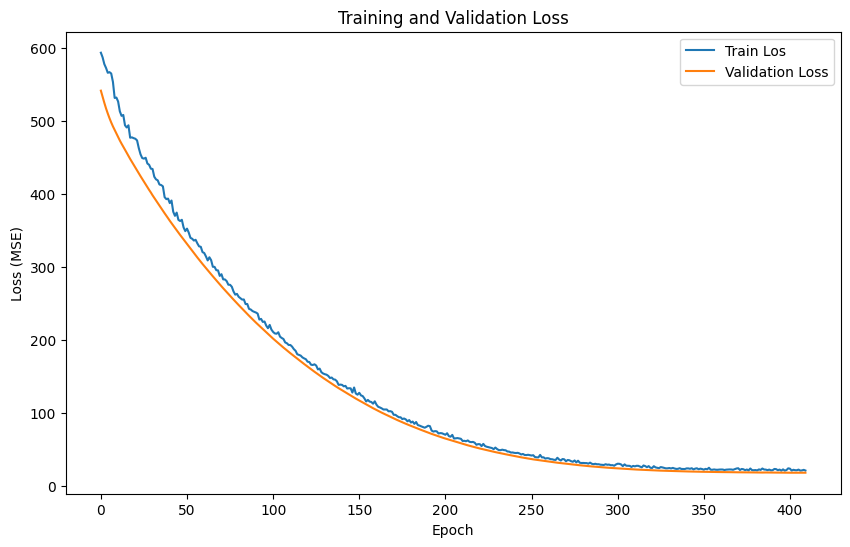

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label ='Train Los')
plt.plot(val_losses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


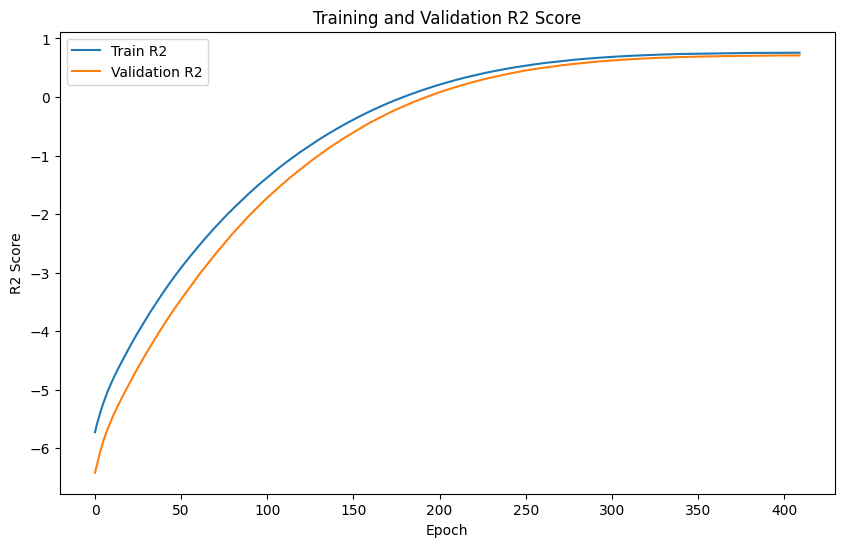

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(train_r2, label = 'Train R2')
plt.plot(val_r2, label = 'Validation R2')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.legend()
plt.title('Training and Validation R2 Score')
plt.show()


Test Loss (MSE): 56.5980
Test R2 Score: 0.6452

 Enter feature values (press enter to use mean value): 
Per capita crime rate by town (CRIM):
3.6135
Proportion of residential land zoned for lots over 25,000 sq.ft. (ZN):
11.3636
Proportion of non-retail business acres per town (INDUS):
11.1368
Charles River dummy variable (1 if tract bounds river, 0 otherwise) (CHAS):
0.0692
Nitric oxides concentration (parts per 10 million) (NOX):
0.5547
Average number of rooms per dwelling (RM):
6.2846
Proportion of owner-occupied units built prior to 1940 (AGE):
68.5749
Weighted distances to five Boston employment centers (DIS):
3.795
Index of accessibility to radial highways (RAD):
9.5494
Full-value property-tax rate per $10,000 (TAX):
408.2372
Pupil-teacher ratio by town (PTRATIO):
18.4555
1000 * (Bk - 0.63)², where Bk is the proportion of Black residents (B):
356.674
Percentage of lower status of the population (LSTAT):
12.6531

 Predicted House: $ 21.95


In [48]:
def predict_with_pertial_input(model, scaler, rm_value, sqft_approx=None):
  mean_input = np.zeros(13)
  mean_input[5] = rm_value

  if sqft_approx:
    mean_input[12] = max(0, 15 - sqft_approx / 100)

  feature_means = [
    3.6135,   # CRIM
    11.3636,  # ZN
    11.1368,  # INDUS
    0.0692,   # CHAS
    0.5547,   # NOX
    6.2846,   # RM (overwritten by user input)
    68.5749,  # AGE
    3.7950,   # DIS
    9.5494,   # RAD
    408.2372, # TAX
    18.4555,  # PTRATIO
    356.6740, # B
    12.6531   # LSTAT (adjusted if sqft_approx provided)
]


  for i in range(len(mean_input)):
    if mean_input[i] == 0 and i != 5 and (i != 12 or not sqft_approx):
      mean_input[i] = feature_means[i]

  scaled_input = scaler.transform([mean_input])

  with torch.no_grad():
    input_tensor = torch.FloatTensor(scaled_input).to(device)
    predicted_price = model(input_tensor).cpu().numpy()[0][0]
  return predicted_price



rm_value = float(input("Enter the number of rooms (RM): "))
sqft_approx = input("Enter approximate square footage (optional, press Enter to skip): ")
sqft_approx = float(sqft_approx) if sqft_approx else None

predicted_price = predict_with_pertial_input(model, scaler, rm_value, sqft_approx)
print(f"Predicted House Price: ${predicted_price:,.2f}")



Enter the number of rooms (RM): 5
Enter approximate square footage (optional, press Enter to skip): 3000
Predicted House Price: $21.87
